# Overview
The idea here is simple, we split the dataset into parts and train two gradient boosting model lightGBM taking each split as validation set only once (just like K fold cross validation where K = 2). We add some features based on the public kernel found on kaggle which helped us to reduce overfitting. More information is given in the "akashkewar\@gmail.com_CS1.pdf" file

In [3]:
# importing dependencies
import numpy as np
import pandas as pd
import os
import pickle
import random
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
import lightgbm as lgb
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


# path to files
path = "/kaggle/input/ashrae-energy-prediction/"
path_train = path + "train.csv"
path_test = path + "test.csv"
path_building = path + "building_metadata.csv"
path_weather_train = path + "weather_train.csv"
path_weather_test = path + "weather_test.csv"

# random seed to reproduce the results
random.seed(0)

# Utility Functions
Functions that are frequently used like saving object into the memory, parsing datetime object, merging two dataframes and reducing the memory usage by dataframe object.

In [4]:
def save_object(obj, filename):
  """Save the object into the disk"""
  
  dirname = os.path.dirname(filename)
  if not os.path.exists(dirname):
    os.makedirs(dirname)
  
  with open(filename, 'wb') as output: 
    pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
  """Load the object into the disk"""
  with open(filename, 'rb') as output:
    return pickle.load(output)

def add_time_features(df):
    """Add date time features by parsing timestamp"""
    # add dayofyear column
    df["dayofyear"] = df.timestamp.dt.dayofyear
    # add day column
    df["day"] = df.timestamp.dt.day
    # add week column
    df["weekday"] = df.timestamp.dt.weekday
    # add hour column
    df["hour"] = df.timestamp.dt.hour
    # add month column
    df["month"] = df.timestamp.dt.month
    # add weekend column
    df["weekend"] = df.timestamp.dt.weekday.apply(lambda x: 0 if x <5 else 1)

def merge_all(df, weather_df, building_meta_df):
  """Merge all data"""
  # merge train and bulding meta data on building id
  merged = df.merge(building_meta_df,
                    how= "left",
                    on= ["building_id"])
  
  # merge last merged df with weather data
  df_merged = merged.merge(weather_df, how= "left",
                           on= ["site_id", "timestamp"])
  # clean up
  del df, weather_df, building_meta_df, merged
  gc.collect()

  return df_merged

# Original code from  https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    # print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

# Loading The Data
Loading the train data and reduce the memory used by dataframe, label encode all the non-numeric columns.

In [5]:
# load training data in dataframes
df_train = pd.read_csv(path_train)
df_building = pd.read_csv(path_building)
df_weather_train = pd.read_csv(path_weather_train)

# reducing memory usages
reduce_mem_usage(df_train, use_float16=True)
reduce_mem_usage(df_building, use_float16=True)
reduce_mem_usage(df_weather_train, use_float16=True)

# converting non-numeric data to numeric form
le = LabelEncoder()
df_building.primary_use = le.fit_transform(df_building.primary_use)

Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


# Preprocessing And Feature Engineering
Add features, merge dataframes, apply transformations, dropping redundent columns.

In [6]:
def preprocessing(df, df_building, df_weather, test=False):
    """
    Making dataset ready to be fed into the ML model
    """
    # merge all three dataframe
    df = df.merge(df_building, on="building_id", how="left")
    df = df.merge(df_weather, on=["site_id", "timestamp"], how="left")
    
    # apply log1p to the area (making it more normal and dealing with extreme values)
    df.square_feet = np.log1p(df.square_feet)
    
    # sort the training dataframe timewise
    if not test:
        df.sort_values("timestamp", inplace=True)
        df.reset_index(drop= True, inplace=True)

    
    # change the dataformat to ease the operations
    df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d %H:%M:%S")
    
    # call the garbage collector
    gc.collect()
    
    # add time features by parsing time stamp
    add_time_features(df)
    '''
    ***************************************************************************/
    \*  Title: [3rd Place] Solution
    \*  Author: eagle4
    \*  Date: 2011
    \*  Code version: N/A
    \*  Availability: https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124984
    '''
    ##############################################################
    
    """
    "It is supposed to calculate the solar horizontal radiation coming into the building"
    """
    
    latitude_dict = {0 :28.5383,
                    1 :50.9097,
                    2 :33.4255,
                    3 :38.9072,
                    4 :37.8715,
                    5 :50.9097,
                    6 :40.7128,
                    7 :45.4215,
                    8 :28.5383,
                    9 :30.2672,
                    10 :40.10677,
                    11 :45.4215,
                    12 :53.3498,
                    13 :44.9375,
                    14 :38.0293,
                    15: 40.7128}

    df['latitude'] = df['site_id'].map(latitude_dict)
    df['solarHour'] = (df['hour']-12)*15 # to be removed
    df['solarDec'] = -23.45*np.cos(np.deg2rad(360*(df['day']+10)/365)) # to be removed
    df['horizsolar'] = np.cos(np.deg2rad(df['solarHour']))*np.cos(np.deg2rad(df['solarDec']))*np.cos(np.deg2rad(df['latitude'])) + np.sin(np.deg2rad(df['solarDec']))*np.sin(np.deg2rad(df['latitude']))
    df['horizsolar'] = df['horizsolar'].apply(lambda x: 0 if x <0 else x)
    
    ##############################################################
    
    # Holiday feature
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    df["is_holiday"] = df.timestamp.dt.date.astype("str").isin(holidays).astype(int)
        
    # Drop redundent columns
    '''
    Drop the columns which contains lots of missing values and have
    less or no effect on predicting the target
    '''
    drop_features = ["timestamp", 'floor_count', 'year_built']
    df.drop(drop_features, axis=1, inplace=True)
    
    # If test dataframe, return rows ids and test dataframe
    if test:
        row_ids = df.pop("row_id")
        return df, row_ids
    
    # If train dataframe, return target and train dataframe
    else:
        # Select building 1099 meter 2 and remove the rows from the dataset
        df.drop(df[(df.meter == 2) & (df.building_id == 1099)].index, axis= "index", inplace=True)
        
        # Get the target and apply log transformation scaled by the building area
        y = np.log1p(df.pop("meter_reading")/df.square_feet) # https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124709
        
        return df, y

In [7]:
# preprocess train data
X_train_df, y_train_df = preprocessing(df_train, df_building, df_weather_train)

# del df_train, df_weather_train
gc.collect()

153

# Gridsearch To Find Best Hyper Parameter Value

We will perform gridsearch manually here by going via each and every values to be searched. We will save each model and parameters onto the disk to facilitate loading the same later.

In [ ]:
# categorical features list
categorical_features = ["building_id",
     "site_id",
     "meter",
     "primary_use",
     "hour",
     "weekday",
     'dayofyear',
     'day',
     'hour',
     'month',
     'is_holiday']

# split the data into two parts
X_1, y_1 = X_train_df[:X_train_df.shape[0]//2], y_train_df[:y_train_df.shape[0]//2]
X_2, y_2 = X_train_df[X_train_df.shape[0]//2:], y_train_df[y_train_df.shape[0]//2:]

# create dataset object of both the splits
dataset_1 = lgb.Dataset(X_1, label=y_1, categorical_feature=categorical_features, free_raw_data=False)
dataset_2 = lgb.Dataset(X_2, label=y_2, categorical_feature=categorical_features, free_raw_data=False)


# constant parameters for our model
params = {}
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['verbose'] = 0

# number of base learners
n_round = 1000

# parameters and corresponding values to search
num_leaves_list = [40, 80, 90, 512]
feature_fraction_list = [0.85, 1]
learning_rate_list = [0.05, 0.1, 0.7]
reg_lambda_list = [0.1, 2, 10]
count = 0

'''
For each parameter value, train the model and log the stats
'''

for prms in params_list:
    
    # number of leaves
    params[prms[0]] = leaves
    
    # feature fraction to train base learner
    params[prms[1]] = feature_fraction
    
    # how fast we wanna learn from the data
    params[prms[2]] = learning_rate
    
    # regularization to prevent overfitting
    params[prms[3]] = reg_lambda

    print("Training first model")

    # train fist model with 1nd split and validate on second
    model_1 = lgb.train(params,
                        train_set=dataset_1,
                        num_boost_round=n_round,
                        valid_sets=(dataset_1, dataset_2),
                        verbose_eval=200,
                        early_stopping_rounds=200)

    print("Training second model")

    # train second model with 2nd split and validate on first
    model_2 = lgb.train(params,
                        train_set=dataset_2,
                        num_boost_round=n_round,
                        valid_sets=(dataset_2, dataset_1),
                        verbose_eval=200,
                        early_stopping_rounds=200)
    
    # get the training rmse of both the models
    rmse_1_train = model_1.best_score["training"]["rmse"]
    rmse_2_train = model_2.best_score["training"]["rmse"]
    
    # get the validation rmse of both the models
    rmse_1_val = model_1.best_score["valid_1"]["rmse"]
    rmse_2_val = model_2.best_score["valid_1"]["rmse"]

    # traning mean
    t_mean = (rmse_1_train + rmse_2_train)/2

    # validation mean
    v_mean = (rmse_1_val + rmse_2_val)/2

    # train and validation mean
    rmse = (t_mean + v_mean) /2
    
    # save all the stats into the disk
    save_object([count, rmse, params,t_mean, v_mean, model_1, model_2], f"./count_rmse_params_t_mean_v_mean_model_list_{count}.pkl")
    
    # increment the count
    count += 1
    
    # call garbage collector
    gc.collect()

In [ ]:
# list to hold gridseach stats
count_list = []
rmse_list = []
params_list = []
t_mean_list = []
v_mean_list = []
model_1_list = []
model_2_list = []

# load the stats of all 72 models
for id_ in range(72):
    count, rmse, params,t_mean, v_mean, model_1, model_2 = load_object(f"../input/ashrae-gridsearch/count_rmse_params_t_mean_v_mean_model_list_{id_}.pkl")
    count_list.append(count)
    rmse_list.append(rmse)
    params_list.append(params)
    t_mean_list.append(t_mean)
    v_mean_list.append(v_mean)
    model_1_list.append(model_1)
    model_2_list.append(model_2)

# convert to pandas df
df_gs_stats = pd.DataFrame({"count": count_list,
                            "t_mean": t_mean_list,
                            "v_mean": v_mean_list,
                            "mean_rmse":rmse_list,
                            "params": params_list,
                            "model_1": model_1_list,
                            "model_2": model_2_list})
# save dataframe as pickle file on disk
df_gs_stats.to_pickle("./gridsearch_stats.pkl")

# Load Gridsearch Stats And Select Best Model
Loading all the saved models we had trained in gridsearch phase and select best model based on train and validation loss.

In [8]:
# load the girdsearch stats file
gridsearch_stats = pd.read_pickle("../input/df-gridsearch-stats/gridsearch_stats.pkl")
gridsearch_stats.reset_index(drop=True, inplace=True)

In [9]:
# we will select model based on training mean and validation mean RMSE (the lower the better)
tmp = gridsearch_stats[["t_mean", "v_mean"]].copy(deep= True).iloc[:40]

# scaling the validation scores for visualization purpose
tmp.v_mean = tmp.v_mean/2

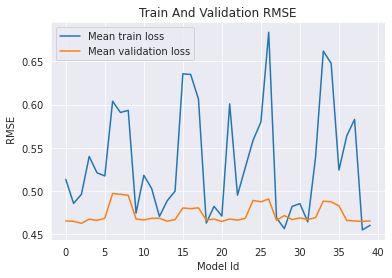

In [16]:
# draw a line graph to analyse RMSE
tmp[["t_mean", "v_mean"]].plot()
sns.set_style("darkgrid")
plt.title("Train And Validation RMSE")
plt.xlabel("Model Id")
plt.ylabel(" RMSE")
plt.legend(["Train loss"])
plt.legend(["Mean train loss", "Mean validation loss"])

Best model seems to be 38th where train and validation loss is at minimum. We will choose 38th model and submit our predictions on test set to get the leaderboard score.

# Preprocessing Test Data And Making Predictions
As test dataset is huge, we will process test data in chunks (10 chunks), get the prediction on each chunk, update the prediction matrix, clear the memory and repeat for each chunk.

In [17]:
# load test data
df_test = pd.read_csv(path_test)
df_weather_test = pd.read_csv(path_weather_test)
df_building = pd.read_csv(path_building)

# reducing memory usages
reduce_mem_usage(df_test, use_float16=True)
reduce_mem_usage(df_weather_test, use_float16=True)

# convert non-numeric data into numeric
le = LabelEncoder()
df_building.primary_use = le.fit_transform(df_building.primary_use)

In [18]:
# best model id
model_id = 38

# load the best model we have found after gridsearch
model_1 = gridsearch_stats.iloc[model_id].model_1
model_2 = gridsearch_stats.iloc[model_id].model_2

# number of chunks to divide test set in
chunk = 10

# total rows in test dataset
total_rows = 41697600

# holds predictions
y_pred = np.zeros(total_rows)

# number of rows per chunk
n_rows = total_rows//chunk

# for each chunk, preprocess the data and save the predictions

for i, s in enumerate(range(0, total_rows, n_rows)):
    
    # get the data for current chunk
    df = df_test.iloc[s:s+n_rows].copy(deep= True)
    
    # preprocess current chunk
    X_test, row_ids = preprocessing(df,
                                   df_building,
                                   df_weather_test,
                                   test=True)
    
    '''
    Get the prediction on current chunk using both the models.
    We are undoing the log transformation and building area scaling.
    '''
    y_pred[row_ids] +=  (np.expm1(model_1.predict(X_test, num_iteration=model_1.best_iteration))* X_test.square_feet)/2
    y_pred[row_ids] +=  (np.expm1(model_2.predict(X_test, num_iteration=model_2.best_iteration)) * X_test.square_feet)/2
    
    # clear the memory
    del df, X_test, row_ids
    gc.collect()
    
    # update the user
    print(f"Done {i + 1}/{chunk}")

Done 1/10
Done 2/10
Done 3/10
Done 4/10
Done 5/10
Done 6/10
Done 7/10
Done 8/10
Done 9/10
Done 10/10


# Making Submission
Preparing submission file and submitting it to ASHRAE competition.

In [19]:
# prepare submission file
'''
As meter reading cannot be negative, we will clip all the negative values to 0
'''
submission = pd.DataFrame({"row_id": range(total_rows), "meter_reading": np.clip(y_pred, a_min=0, a_max=None)})
submission.to_csv("submission.csv", index=False)

# copy the kaggle api key to the home kaggle directory
!mkdir ~/.kaggle/
!mv ../input/apikey/kaggle.json ~/.kaggle/

# submmit to competition
!kaggle competitions submit -c "ashrae-energy-prediction" -f "./submission.csv" -m "appliedAIcourse_CS1"

# clear the memory
del submission
gc.collect()

mv: cannot remove '../input/apikey/kaggle.json': Read-only file system
100%|██████████████████████████████████████| 1.05G/1.05G [00:32<00:00, 34.5MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III

0

# Submission Results
**Here we get private score of 1.322 and public score of 1.137 which is around 85% private score improvement and around 83% public score improvement since last submission which was 1.550 private score and 1.377 public score**.
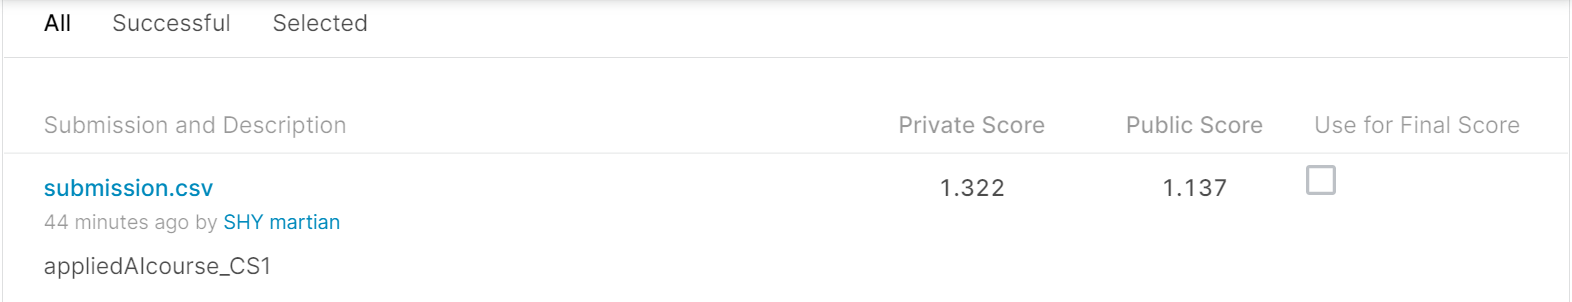